# Credit Card Approval - Model Training
This notebook trains multiple classification models and saves the best performing model

**Prerequisites:** All required packages must be installed first
```bash
pip install -r requirements.txt
```

**MLflow Tracking:** All models, parameters, and metrics are logged to MLflow  
**Output:** Best model saved to `../models/`

In [13]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import joblib
from pathlib import Path
import time

from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report
)

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [14]:
# End any active run first to prevent conflicts
mlflow.end_run()

# Initialize MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("credit_card_approval_model_training")


# Create model directory
model_dir = Path('../models')
model_dir.mkdir(parents=True, exist_ok=True)

print(f"✓ MLflow tracking URI: http://127.0.0.1:5000")
print(f"✓ Model directory: {model_dir}")

✓ MLflow tracking URI: http://127.0.0.1:5000
✓ Model directory: ../models


## 1. Load Processed Data

In [15]:
# Load processed data
data_dir = Path('../data/processed')

X_train = pd.read_csv(data_dir / 'X_train.csv')
X_test = pd.read_csv(data_dir / 'X_test.csv')
y_train = pd.read_csv(data_dir / 'y_train.csv')['Label']
y_test = pd.read_csv(data_dir / 'y_test.csv')['Label']

print(f"✓ Data loaded successfully")
print(f"\n📊 Training Set: {X_train.shape}")
print(f"📊 Test Set: {X_test.shape}")
print(f"\nFeatures: {list(X_train.columns)}")

✓ Data loaded successfully

📊 Training Set: (57996, 5)
📊 Test Set: (14500, 5)

Features: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']


## 2. Define Models

In [16]:
# Define model configurations (will create fresh instances in training loop)
model_configs = {
    'AdaBoost': {
        'class': AdaBoostClassifier,
        'params': {'n_estimators': 100, 'learning_rate': 1.0, 'random_state': 42}
    },
    'XGBoost': {
        'class': XGBClassifier,
        'params': {'n_estimators': 500, 'max_depth': 3, 'random_state': 42, 'eval_metric': 'logloss'}
    },
    'LightGBM': {
        'class': LGBMClassifier,
        'params': {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.02, 'random_state': 42, 'verbose': -1}
    },
    'CatBoost': {
        'class': CatBoostClassifier,
        'params': {'iterations': 250, 'depth': 8, 'learning_rate': 0.02, 'random_state': 42, 'verbose': 0}
    },
    'Naive Bayes': {
        'class': GaussianNB,
        'params': {}
    }
}

print(f"✓ Defined {len(model_configs)} model configurations")
print(f"\nModels:")
for name in model_configs.keys():
    print(f"  - {name}")

✓ Defined 5 model configurations

Models:
  - AdaBoost
  - XGBoost
  - LightGBM
  - CatBoost
  - Naive Bayes


## 3. Train and Evaluate Models

In [17]:
# Store results
results = []
trained_models = {}

print("="*80)
print("TRAINING MODELS")
print("="*80)

for model_name, config in model_configs.items():
    print(f"\n{'='*80}")
    print(f"Training: {model_name}")
    print(f"{'='*80}")
    
    # Create FRESH model instance for each training run
    model = config['class'](**config['params'])
    print(f"✓ Created fresh {model_name} instance")
    
    # Start MLflow run for this model
    with mlflow.start_run(run_name=model_name):
        # Log model parameters
        mlflow.log_param("model_type", model_name)
        mlflow.log_params(model.get_params())
        
        # Train model
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
        
        # Log metrics to MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        if roc_auc is not None:
            mlflow.log_metric("roc_auc", roc_auc)
        mlflow.log_metric("training_time", training_time)
        
        # Log model using 'artifact_path' parameter
        try:
            if 'XGBoost' in model_name:
                mlflow.xgboost.log_model(model, artifact_path="model")
            elif 'LightGBM' in model_name:
                mlflow.lightgbm.log_model(model, artifact_path="model")
            elif 'CatBoost' in model_name:
                mlflow.catboost.log_model(model, artifact_path="model")
            else:
                mlflow.sklearn.log_model(model, artifact_path="model")
        except Exception as e:
            print(f"⚠️  Warning: Could not log model to MLflow: {e}")
            print(f"   Continuing with training...")
        
        # Print results
        print(f"\nResults:")
        print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
        print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
        print(f"  F1-Score:  {f1:.4f}")
        if roc_auc is not None:
            print(f"  ROC-AUC:   {roc_auc:.4f}")
        print(f"  Training Time: {training_time:.2f}s")
        
        # Store results
        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc,
            'Training Time (s)': training_time
        })
        
        trained_models[model_name] = model
        
        print(f"✓ {model_name} training completed")

print(f"\n{'='*80}")
print("ALL MODELS TRAINED")
print(f"{'='*80}")

TRAINING MODELS

Training: AdaBoost
✓ Created fresh AdaBoost instance


2025/12/07 19:53:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results:
  Accuracy:  0.7314 (73.14%)
  Precision: 0.7094 (70.94%)
  Recall:    0.7824 (78.24%)
  F1-Score:  0.7441
  ROC-AUC:   0.8130
  Training Time: 13.43s
✓ AdaBoost training completed
🏃 View run AdaBoost at: http://127.0.0.1:5000/#/experiments/3/runs/a88e7daab717430b9c7b049f31987416
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3

Training: XGBoost
✓ Created fresh XGBoost instance


2025/12/07 19:53:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results:
  Accuracy:  0.9592 (95.92%)
  Precision: 0.9661 (96.61%)
  Recall:    0.9518 (95.18%)
  F1-Score:  0.9589
  ROC-AUC:   0.9916
  Training Time: 1.07s
✓ XGBoost training completed
🏃 View run XGBoost at: http://127.0.0.1:5000/#/experiments/3/runs/9b7059ae05cc4e348be0872dbeca0ae0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3

Training: LightGBM
✓ Created fresh LightGBM instance


2025/12/07 19:54:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results:
  Accuracy:  0.8972 (89.72%)
  Precision: 0.9011 (90.11%)
  Recall:    0.8921 (89.21%)
  F1-Score:  0.8966
  ROC-AUC:   0.9658
  Training Time: 0.53s
✓ LightGBM training completed
🏃 View run LightGBM at: http://127.0.0.1:5000/#/experiments/3/runs/81588d300bc6465d8b06dafc60c21ab3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3

Training: CatBoost
✓ Created fresh CatBoost instance


2025/12/07 19:55:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results:
  Accuracy:  0.9136 (91.36%)
  Precision: 0.9211 (92.11%)
  Recall:    0.9044 (90.44%)
  F1-Score:  0.9127
  ROC-AUC:   0.9746
  Training Time: 3.28s
✓ CatBoost training completed
🏃 View run CatBoost at: http://127.0.0.1:5000/#/experiments/3/runs/e056af61be864db99ca3fc1ae5f91c00
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3

Training: Naive Bayes
✓ Created fresh Naive Bayes instance


2025/12/07 19:55:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results:
  Accuracy:  0.7043 (70.43%)
  Precision: 0.6879 (68.79%)
  Recall:    0.7461 (74.61%)
  F1-Score:  0.7158
  ROC-AUC:   0.7813
  Training Time: 0.01s
✓ Naive Bayes training completed
🏃 View run Naive Bayes at: http://127.0.0.1:5000/#/experiments/3/runs/330ca60824fb464db79cf1a798d027cf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3

ALL MODELS TRAINED


## 4. Compare Models

In [18]:
# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False)

print("="*80)
print("MODEL COMPARISON")
print("="*80)
display(results_df)

# Save results
results_path = model_dir / 'model_comparison.csv'
results_df.to_csv(results_path, index=False)
print(f"\n✓ Results saved to {results_path}")

MODEL COMPARISON


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training Time (s)
1,XGBoost,0.959241,0.966068,0.951789,0.958876,0.991557,1.070477
3,CatBoost,0.913586,0.921075,0.904407,0.912665,0.974552,3.275832
2,LightGBM,0.897241,0.901074,0.892112,0.896571,0.965752,0.534561
0,AdaBoost,0.731379,0.709419,0.782429,0.744137,0.813002,13.430988
4,Naive Bayes,0.704276,0.687938,0.746098,0.715838,0.781251,0.014619



✓ Results saved to ../models/model_comparison.csv


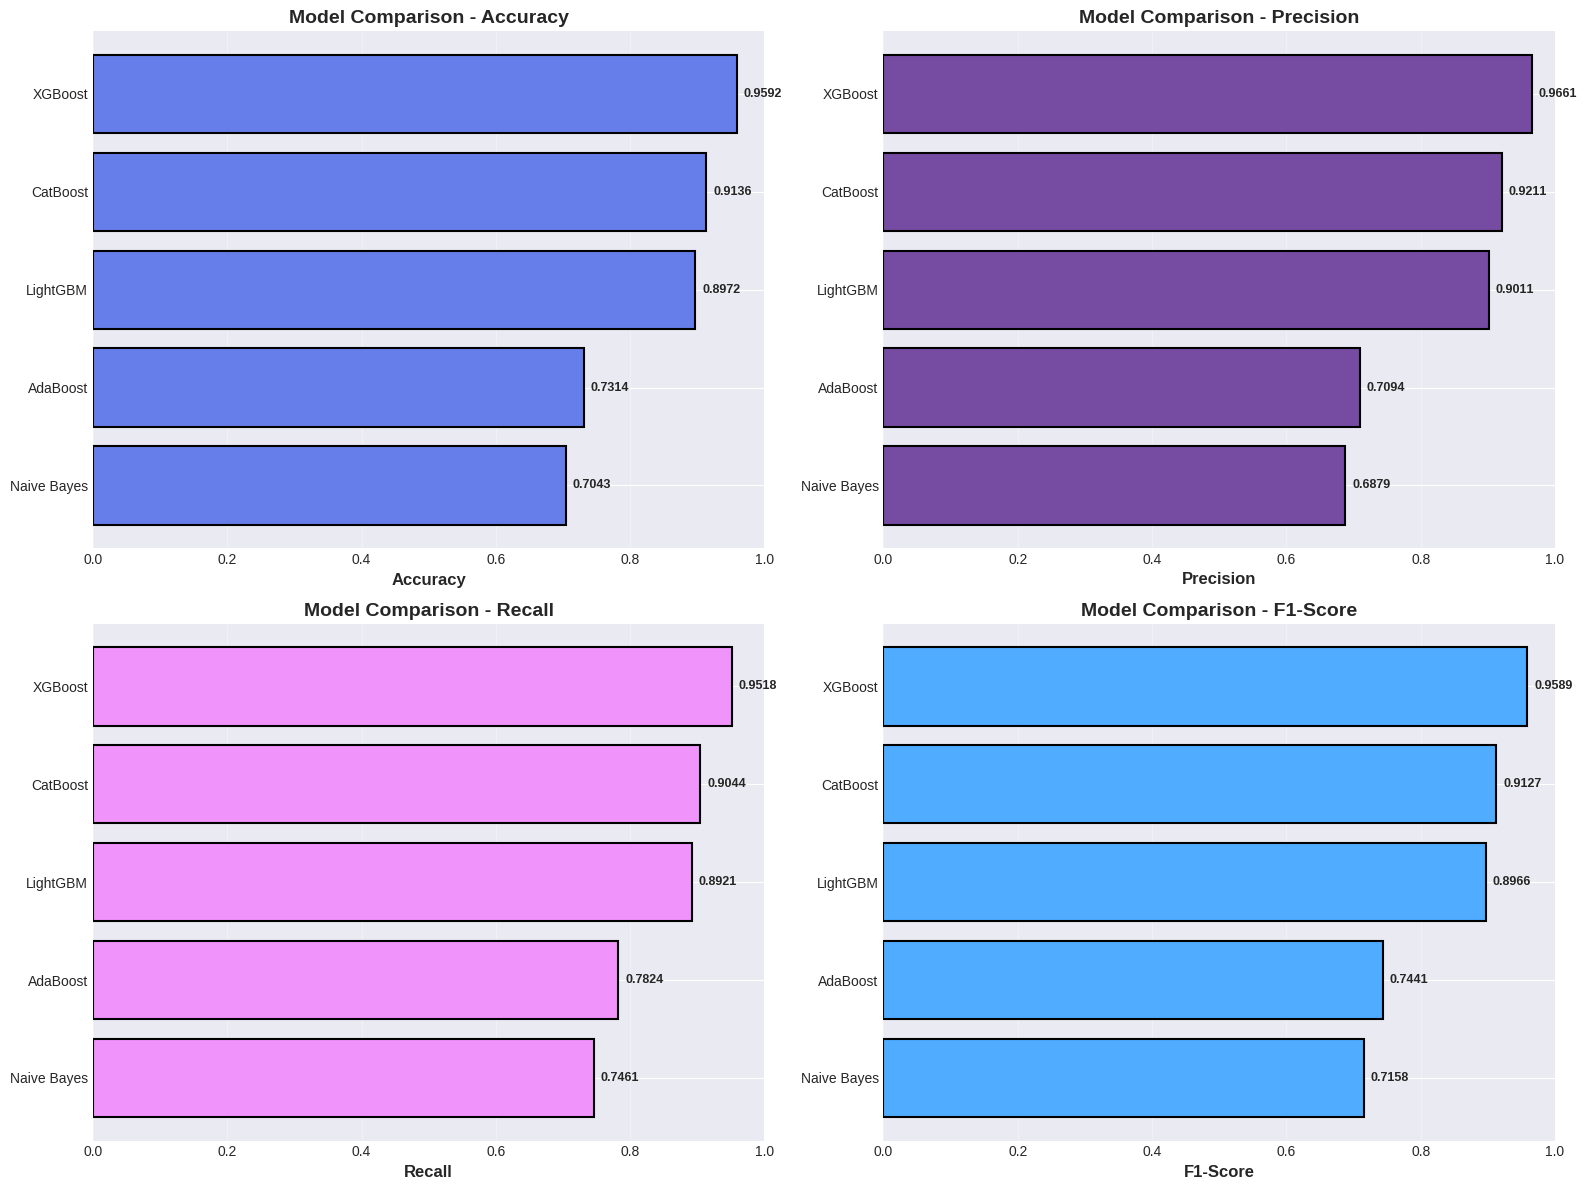

✓ Comparison plot saved to ../models/model_comparison.png


In [19]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#667eea', '#764ba2', '#f093fb', '#4facfe']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    data = results_df.sort_values(metric, ascending=True)
    ax.barh(data['Model'], data[metric], color=color, edgecolor='black', linewidth=1.5)
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'Model Comparison - {metric}', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3, axis='x')
    ax.set_xlim([0, 1])
    
    # Add value labels
    for i, v in enumerate(data[metric]):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig(model_dir / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Comparison plot saved to {model_dir / 'model_comparison.png'}")

## 5. Select Best Model

In [20]:
# Select best model based on F1-Score
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print("="*80)
print("BEST MODEL SELECTION")
print("="*80)
print(f"\n🏆 Best Model: {best_model_name}")
print(f"\nPerformance Metrics:")
for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    if col in results_df.columns:
        value = results_df.iloc[0][col]
        if pd.notna(value):
            print(f"  {col}: {value:.4f}")

# Start MLflow run for best model
with mlflow.start_run(run_name=f"best_model_{best_model_name}"):
    mlflow.log_param("model_type", best_model_name)
    mlflow.log_param("best_model", True)
    
    # Log all metrics
    for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Training Time (s)']:
        if col in results_df.columns:
            value = results_df.iloc[0][col]
            if pd.notna(value):
                # Clean metric name: remove parentheses, replace spaces and dashes with underscores
                metric_name = col.lower().replace(' ', '_').replace('-', '_').replace('(', '').replace(')', '')
                mlflow.log_metric(metric_name, value)
    
    # Log model using 'artifact_path' parameter
    try:
        if 'XGBoost' in best_model_name:
            mlflow.xgboost.log_model(best_model, artifact_path="best_model")
        elif 'LightGBM' in best_model_name:
            mlflow.lightgbm.log_model(best_model, artifact_path="best_model")
        elif 'CatBoost' in best_model_name:
            mlflow.catboost.log_model(best_model, artifact_path="best_model")
        else:
            mlflow.sklearn.log_model(best_model, artifact_path="best_model")
    except Exception as e:
        print(f"⚠️  Warning: Could not log model to MLflow: {e}")
        print(f"   Model will still be saved locally.")
    
    # Log comparison artifacts
    try:
        mlflow.log_artifact(str(model_dir / 'model_comparison.png'))
        mlflow.log_artifact(str(model_dir / 'model_comparison.csv'))
    except Exception as e:
        print(f"⚠️  Warning: Could not log artifacts to MLflow: {e}")
    
    # Fix f-string formatting error by evaluating ROC-AUC value first
    roc_auc_value = results_df.iloc[0]['ROC-AUC']
    roc_auc_str = f"{roc_auc_value:.4f}" if pd.notna(roc_auc_value) else 'N/A'
    
    # Create and log training summary
    summary_text = f"""
MODEL TRAINING COMPLETED

Models Trained: {len(model_configs)}
  {', '.join(model_configs.keys())}

Best Model: {best_model_name}
  - Accuracy:  {results_df.iloc[0]['Accuracy']:.4f}
  - Precision: {results_df.iloc[0]['Precision']:.4f}
  - Recall:    {results_df.iloc[0]['Recall']:.4f}
  - F1-Score:  {results_df.iloc[0]['F1-Score']:.4f}
  - ROC-AUC:   {roc_auc_str}

Training Data:
  - Training samples: {len(X_train):,}
  - Test samples: {len(X_test):,}
  - Features: {X_train.shape[1]}

Saved Artifacts:
  - Best model: {model_dir / f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl'}
  - Model metadata: {model_dir / 'best_model_metadata.json'}
  - Comparison results: {model_dir / 'model_comparison.csv'}
  - All models logged to MLflow

✅ Ready for model evaluation!
"""
    
    # Save summary to file
    summary_path = model_dir / 'training_summary.txt'
    with open(summary_path, 'w') as f:
        f.write(summary_text)
    
    # Log summary artifact to MLflow (within run context)
    try:
        mlflow.log_artifact(str(summary_path))
        print(f"\n✓ Summary logged to MLflow and saved to {summary_path}")
    except Exception as e:
        print(f"⚠️  Warning: Could not log summary to MLflow: {e}")
        print(f"✓ Summary saved locally to {summary_path}")

BEST MODEL SELECTION

🏆 Best Model: XGBoost

Performance Metrics:
  Accuracy: 0.9592
  Precision: 0.9661
  Recall: 0.9518
  F1-Score: 0.9589
  ROC-AUC: 0.9916


2025/12/07 19:56:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✓ Summary logged to MLflow and saved to ../models/training_summary.txt
🏃 View run best_model_XGBoost at: http://127.0.0.1:5000/#/experiments/3/runs/af086d3f7d1d43c7a4a909d8d75a495c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


## 6. Save Best Model

In [21]:
# Save best model
best_model_path = model_dir / f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_model, best_model_path)

print(f"\n✓ Best model saved to: {best_model_path}")

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'metrics': results_df.iloc[0].to_dict(),
    'trained_on': pd.Timestamp.now().isoformat(),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'features': list(X_train.columns)
}

import json
metadata_path = model_dir / 'best_model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Model metadata saved to: {metadata_path}")


✓ Best model saved to: ../models/best_model_xgboost.pkl
✓ Model metadata saved to: ../models/best_model_metadata.json


## 7. Summary

In [22]:
print("="*80)
print("MODEL TRAINING SUMMARY")
print("="*80)

# Read and display the summary that was created and logged in cell 14
summary_path = model_dir / 'training_summary.txt'
if summary_path.exists():
    with open(summary_path, 'r') as f:
        summary = f.read()
    print(summary)
else:
    print("Summary file not found. Please run cell 14 (Best Model Selection) first.")

MODEL TRAINING SUMMARY

MODEL TRAINING COMPLETED

Models Trained: 5
  AdaBoost, XGBoost, LightGBM, CatBoost, Naive Bayes

Best Model: XGBoost
  - Accuracy:  0.9592
  - Precision: 0.9661
  - Recall:    0.9518
  - F1-Score:  0.9589
  - ROC-AUC:   0.9916

Training Data:
  - Training samples: 57,996
  - Test samples: 14,500
  - Features: 5

Saved Artifacts:
  - Best model: ../models/best_model_xgboost.pkl
  - Model metadata: ../models/best_model_metadata.json
  - Comparison results: ../models/model_comparison.csv
  - All models logged to MLflow

✅ Ready for model evaluation!



In [23]:
# End any active run first to prevent conflicts
mlflow.end_run()

In [24]:
print("\n✅ Model training completed and logged to MLflow")


✅ Model training completed and logged to MLflow
